# Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_json('logins.json', typ='frame') 
# settying typ to 'frame' proved unexpectedly key; I needed to be able to reset the stream of timestamps to an index
# and Series objects (default due to single data column) don't let you mess with the index

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [3]:
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
data.set_index('login_time', drop=False, inplace=True) # keep a copy of the original column so I can count it during resample
data.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [5]:
data15 = data.resample('15T').count()
data15.rename(columns={'login_time':'count'}, inplace=True)
data15.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


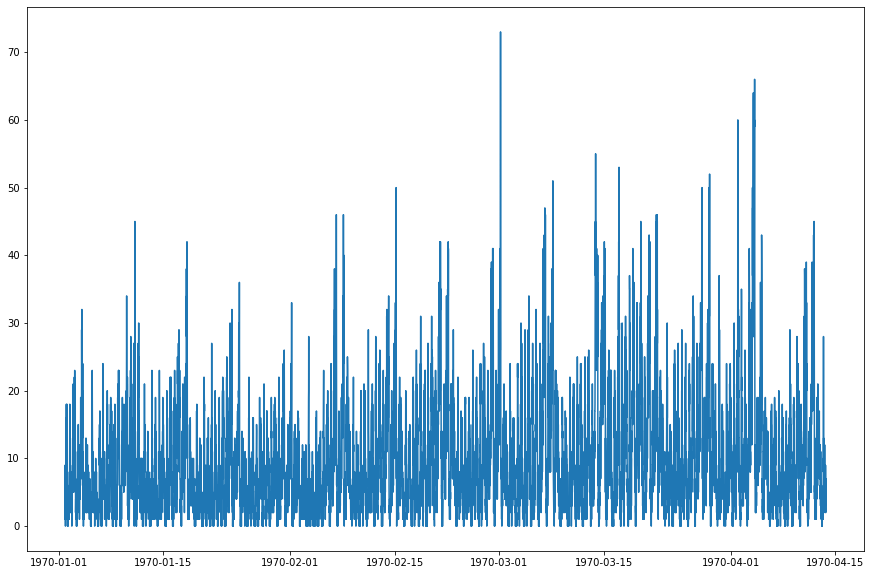

In [6]:
plt.subplots(figsize=(15,10))
plt.plot(data15['count'])
plt.show()

Given that this is supposed to be ride data, I expect it to have a number of different layers of seasonality. I would expect an hourly/time-of-day pattern, a day-of-week pattern, and possibly month or season-of-year shifts in demand. Given that there are four months of data, we wouldn't see if there are changes in demand over summer, fall, or the end-of-year holiday season.

Text(0.5, 1.0, 'Login Counts by Hour of Day')

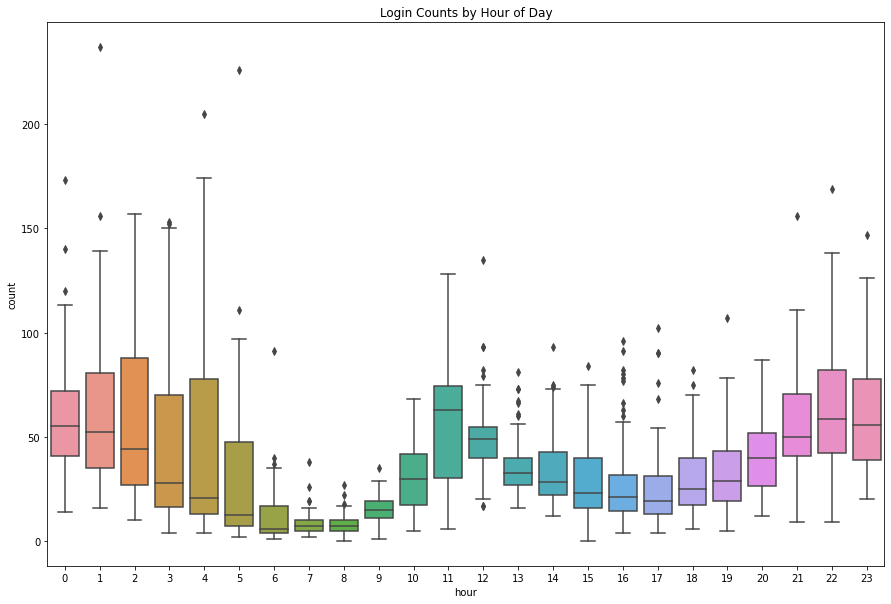

In [7]:
datah = data.resample('60T').count()
datah.rename(columns={'login_time':'count'}, inplace=True)
datah['hour'] = datah.index.hour
plt.subplots(figsize=(15,10))
sns.boxplot(x='hour', y='count', data=datah)
plt.title('Login Counts by Hour of Day')

Plotted hourly, I see a great deal of variability in the midnight to 5AM range, very low counts in the 6-9 AM range (does nobody use this service to get to work?), an odd-looking spike in both demand and variability at 11 AM, and a good deal of evening traffic.

Text(0.5, 1.0, 'Login counts by day of week')

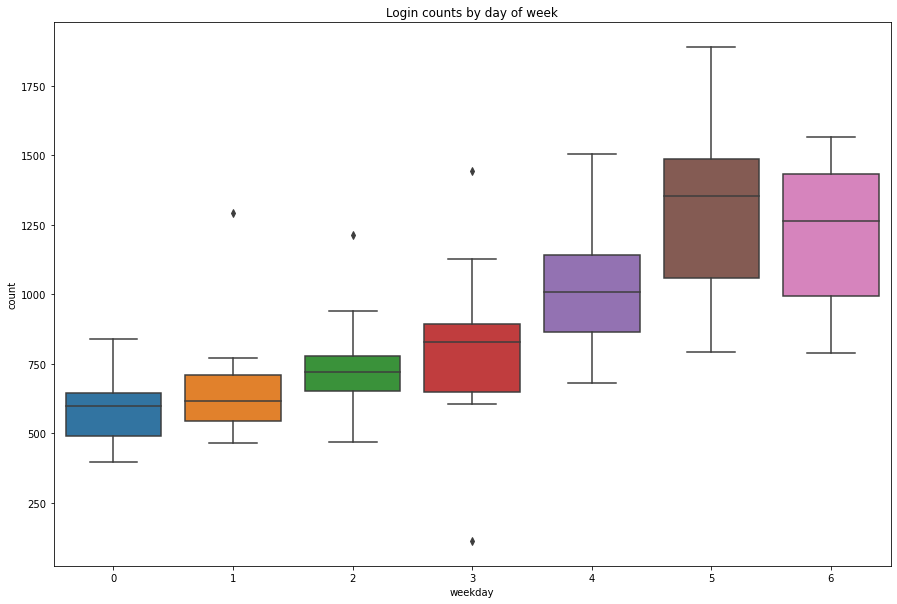

In [8]:
dataw = data.resample('1D').count()
dataw.rename(columns={'login_time':'count'}, inplace=True)
dataw['weekday'] = dataw.index.weekday
plt.subplots(figsize=(15,10))
sns.boxplot(x='weekday', y='count', data=dataw)
plt.title('Login counts by day of week')

Plotted by day of week, my guess that weekends see the most ridership appears confirmed.

Text(0.5, 1.0, 'Login counts by week of year')

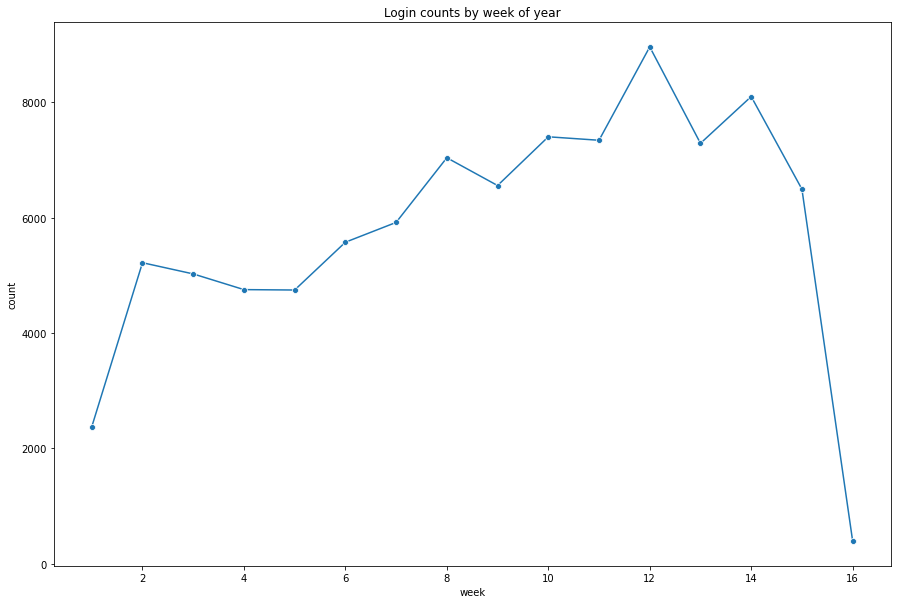

In [9]:
datak = data.resample('1W').count()
datak.rename(columns={'login_time':'count'}, inplace=True)
datak['week'] = pd.Int64Index(datak.index.isocalendar().week)
plt.subplots(figsize=(15,10))
sns.lineplot(x='week', y='count', data=datak, marker='o')
plt.title('Login counts by week of year')

Discounting the first and last weeks which are probably partial, it looks like January is a slow month and then ridership generally trends upward toward April. It might be flattening or just becoming more variable in weeks 12-16, I wouldn't want to guess more without seeing a whole year or better yet multiple years for long-term patterns.

# Part 2 ‐ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    * how you will implement the experiment
    * what statistical test(s) you will conduct to verify the significance of the
observation
    * how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### 1. Key Success Metric
Assuming that Ultimate's driver interface collects data on which cities each driver is available in, I would count the number of drivers offering availability to both cities. If the data are less direct, it might be necessary to create this feature out of information such as each drive's source and destination.

### 2. Experiment Design
* I would collect data for a month prior to the experiment as a baseline, and then offer a randomly selected group of drivers the opportunity to participate in a pilot project for another month. An equally sized group would be left as a control group. We would probably need to communicate to the pilot group that they should avoid discussing the test until a companywide decision is made. 
* Looking over the logins data above, we would want to pay attention to correcting for potentially confounding trends, such as the existence of a normal, seasonal increase or decrease in ridership from one month to the next. As the data will naturally be in a time series, we should test for stationarity (Augmented Dickey-Fuller) and for seasonal autocorrelations (ACF/PACF).
* Perhaps once time-based or other confounding factors are adjusted for, a T-Test could reveal whether the proportion of drivers offering availability in both cities increased significantly as compared to the control group. Tests I have less experience with but have been suggested by online research include time series intervention/interrupted time series analysis, or a structural break test.
* I would also collect information on the amount and frequency of toll reimbursements. We will want to know if this incentive is worth the cost. Does an increase in drivers offering availability in both cities generate a corresponding increase in number and/or value of rides? 

## Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice)

### 1. Brief cleaning and analysis
What fraction of observed users are retained?

In [24]:
data2 = pd.read_json('ultimate_data_challenge.json', typ='frame')
data2['last_trip_date'] = pd.to_datetime(data2['last_trip_date'])
data2['signup_date'] = pd.to_datetime(data2['signup_date'])
data2['Retained_6_month'] = (data2['last_trip_date'] >= (data2['signup_date'] + pd.DateOffset(months=5)))
data2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Retained_6_month
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,False
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [25]:
print('Retained users 6 months after signup: ', data2['Retained_6_month'].sum())
print('Proportion of 6-month users: ', data2['Retained_6_month'].sum()/len(data2))

Retained users 6 months after signup:  12257
Proportion of 6-month users:  0.24514


As far as data cleaning, I would look for spelling discrepancies in the text fields, unlikely numbers in the numeric fields (ratings outside what looks like a 5-point scale, percentages over 100, and the like) and make inquiries about how large outliers need to be before they fall out of the bounds of "normal" for the business.

Also in order to investigate correlations and improve classification I will need to create numeric encoding for boolean features and one-hot encode the text features.

### 2. Prediction
After creating a Boolean column for "is the user retained after 6 months?" this is a classification problem. Are there any features that are highly correlated with retention? 

I would be very interested in feature importance for this model, since I expect the next question we'd want to ask is "how do we increase user retention?". I would probably start by using a decision tree for the ability to explain the model's criteria. We could then propose experiments that would hopefully increase important features and test if these increase retention.

For the chosen model, true positives or recall rate would be a good key indicator. We want to know if it is correctly predicting retained users, and there are fewer downsides to having false positives compared with, say, a spam filter.

### 3. Insights
As I mentioned, the more useful question seems to be WHY do users stay with the platform, or not? If the model indicates that driver rating is an important feature, for instance, could we adjust the assignment system to favor higher-rated drivers, especially for users that are predicted to not be retained? If the model picks some less-logical feature as important, perhaps we should look for confounding factors. If it should pick "phone" as important, maybe the app is less reliable or easy to use on one platform vs another?